## Compare track cuts 

Attempts to understand these track parameters. 

track_cuts_1 config: 

```python
self.cuts_to_toggle = {
            "is_truth_electron" : True,
            "is_reco_electron" : True,
            "one_reco_electron" : True,
            "downstream" : True,
            "good_trkqual" : True,
            "has_hits" : False,
            "within_lhr_max" : False,
            "within_d0" : False,
            "within_t0" : True,
            "within_pitch_angle" : False,
            "unvetoed" : False
        }
```

All loop helix parameter arrays are the same length, which is needed to 2D comparison. 


In [1]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse, Utils
from postprocess import PostProcess

# Process data

In [2]:
# from postprocess import PostProcesss

In [3]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self, file_name=None, file_list_path=None, defname=None, location=None):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class"s __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        self.file_name = file_name 
        self.defname = defname
        self.file_list_path = file_list_path
        
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = location   # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=True,
            verbosity=0
        )

        # Toggle cuts

        self.cuts_to_toggle = {
            "is_truth_electron" : True,
            "is_reco_electron" : True,
            "one_reco_electron" : True,
            "downstream" : True,
            "good_trkqual" : True,
            "has_hits" : False,
            "within_lhr_max" : False,
            "within_d0" : False,
            "within_t0" : True,
            "within_pitch_angle" : False,
            "unvetoed" : False
        }

        self.veto = False # a bit ugly 
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class"s process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(
                this_data, 
                file_name,
                cuts_to_toggle = self.cuts_to_toggle
            )

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

In [4]:
# Execute analysis
cosmic_processor = CosmicProcessor(
    # file_name="/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00012335.root",
    # defname = "nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root",
    file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt",
    location = "disk"
)
    
onspill_results = cosmic_processor.execute()

cosmic_processor = CosmicProcessor(
    # file_name="/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root",
    # defname = "nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.root",
    file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt",
    location = "tape"
)
    
signal_results = cosmic_processor.execute()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 50 processes


Processing: 100%|██████████████████████████████| 100/100 [00:50<00:00,  1.97file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = tape
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 50 processes


Processing: 100%|██████████████████████████████| 100/100 [00:48<00:00,  2.07file/s, successful=100, failed=0]

[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete


In [5]:
# Initialise postprocessor 
postprocessor = PostProcess()

# Execute postprocessor
onspill, _, stats_onspill, _ = postprocessor.execute(onspill_results)
signal, _, stats_signal, _ = postprocessor.execute(signal_results)

[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 11449 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[PostProcess] ✅ Combined arrays, result contains 57022 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats


In [6]:
print(len(onspill))
print(len(onspill))

11449
11449


In [7]:
cut_manager = CutManager()
df_stats_onspill = cut_manager.get_cut_stats(stats=stats_onspill, active_only=True, printout=False)
df_stats_signal = cut_manager.get_cut_stats(stats=stats_signal, active_only=True, printout=False)

[CutManager] ✅ Created cut statistics DataFrame 
[CutManager] ✅ Created cut statistics DataFrame 


In [8]:
display(df_stats_onspill)

,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,267495,100.00,100.00,No selection applied
1,is_reco_electron,True,258586,96.67,96.67,Electron track fits
2,has_trk_front,True,256419,95.86,99.16,Tracks intersect tracker entrance
3,good_trkqual,True,45137,16.87,17.60,Track fit quality > 0.8)
4,within_t0,True,36789,13.75,81.51,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,26331,9.84,71.57,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,True,17328,6.48,65.81,Track parents are electrons (truth PID)
7,one_reco_electron,True,11449,4.28,66.07,One reco electron / event


In [9]:
# display(df_stats_onspill)
display(df_stats_signal)

,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,147342,100.00,100.00,No selection applied
1,is_reco_electron,True,147225,99.92,99.92,Electron track fits
2,has_trk_front,True,144742,98.24,98.31,Tracks intersect tracker entrance
3,good_trkqual,True,79107,53.69,54.65,Track fit quality > 0.8)
4,within_t0,True,57217,38.83,72.33,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,57217,38.83,100.00,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,True,57217,38.83,100.00,Track parents are electrons (truth PID)
7,one_reco_electron,True,57022,38.70,99.66,One reco electron / event


## surface cut 

In [10]:
# data_onspill["trkfit"]

In [16]:
selector = Select()

def apply_trk_ent_cut(data): 

    this_data = ak.copy(data)
    
    # Track front 
    at_trk_front = selector.select_surface(this_data["trkfit"], sid=0) # trksegs-level
    has_trk_front = ak.any(at_trk_front, axis=-1)

    this_data["trkfit"] = this_data["trkfit"][at_trk_front]
    
    # # Then clean up events with no tracks after cuts
    this_data = this_data[ak.any(has_trk_front, axis=-1)]

    print("Done")

    return this_data

onspill = apply_trk_ent_cut(onspill)
signal = apply_trk_ent_cut(signal)

[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done


In [17]:
# print(len(onspill))
# print(len(signal))
# printer = Print()
# # printer.print_n_events(onspill)

## Plot

In [18]:
tag = "1"

In [19]:
plot = Plot()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## nactive

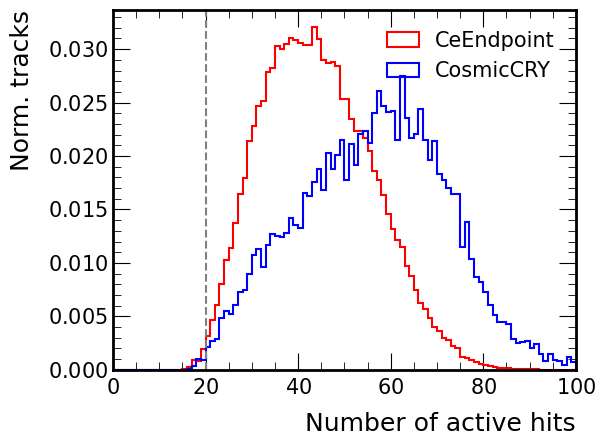

In [20]:
fig, ax = plt.subplots()

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["trk"]["trk.nactive"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trk"]["trk.nactive"], axis=None)
    },
    nbins=100,xmin=0,xmax=100,norm_by_area=True,
    show=False,
    ax=ax,
    xlabel="Number of active hits",
    ylabel="Norm. tracks"
)

ax.axvline(20, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h1o_nactive_{tag}.png", dpi=300)
plt.show()

## Calculate tanDip

In [21]:
vector = Vector()

def calc_pitch_angle(data):

    pvec = vector.get_vector(data["trkfit"]["trksegs"], "mom")
    pt = np.sqrt(pvec["x"]**2 + pvec["y"]**2) # vector.get_vector(signal["trkfit"]["trksegs"], "mom")
    
    p = vector.get_mag(data["trkfit"]["trksegs"], "mom") 
    pz = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]

    cos_theta = pt / p  
    theta = np.arccos(cos_theta)
    tan_dip_check = np.tan(theta)

    tan_dip = pz/pt 

    data["tan_dip"] = tan_dip
    # data["tan_dip_check"] = tan_dip_check

calc_pitch_angle(signal)
calc_pitch_angle(onspill)

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


## Loop helix track cuts summary

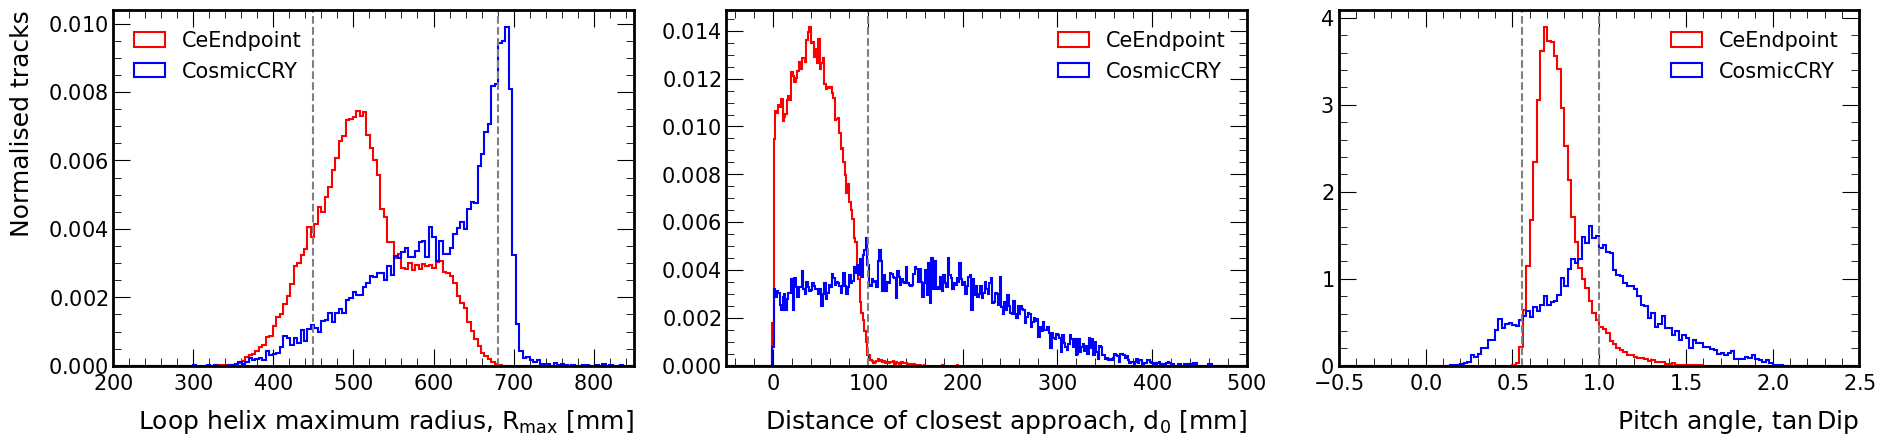

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(6.4*3, 4.8))

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None)
    },
    nbins=75*2,xmin=200,xmax=850,norm_by_area=True,
    show=False,
    ax=ax[0],
    xlabel=r"Loop helix maximum radius, $R_{\text{max}}$ [mm]",
    ylabel="Normalised tracks",
)

ax[0].axvline(450, linestyle="--", color="grey")
ax[0].axvline(680, linestyle="--", color="grey")

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None)
    },
    nbins=350,xmin=-50,xmax=500,norm_by_area=True,
    show=False,
    ax=ax[1],
    xlabel=r"Distance of closest approach, $d_{0}$ [mm]",
    # ylabel="Norm. tracks"
)


ax[1].axvline(100, linestyle="--", color="grey")

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["tan_dip"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["tan_dip"], axis=None)
    },
    nbins=150,xmin=-0.5,xmax=2.5,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[2],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
    # ylabel="Norm. tracks"
)

ax[2].axvline(0.5577350, linestyle="--", color="grey")
ax[2].axvline(1.0, linestyle="--", color="grey")

plt.tight_layout()
plt.savefig(f"../../img/comp/h1o_track_cuts_summary.png", dpi=300)
plt.show()

## R_max

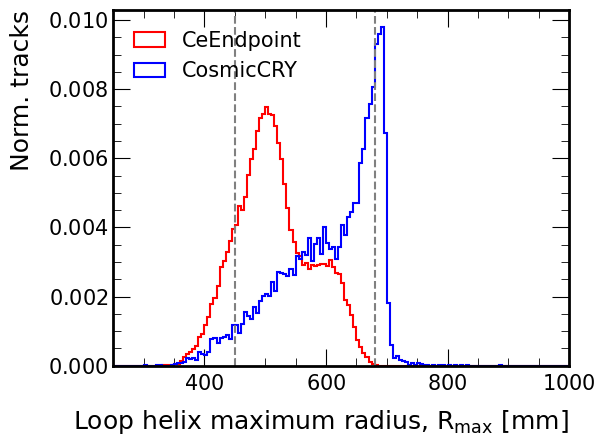

In [23]:
fig, ax = plt.subplots()

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None)
    },
    nbins=75*2,xmin=250,xmax=1000,norm_by_area=True,
    show=False,
    ax=ax,
    xlabel=r"Loop helix maximum radius, $R_{\text{max}}$ [mm]",
    ylabel="Norm. tracks"
)

ax.axvline(450, linestyle="--", color="grey")
ax.axvline(680, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h1o_lhrmax_{tag}.png", dpi=300)
plt.show()

## d_0

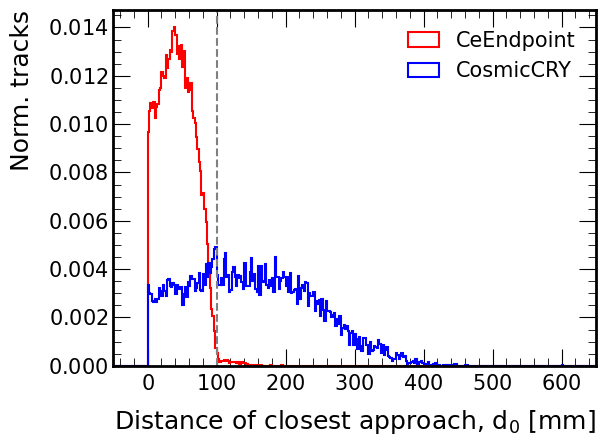

In [24]:
fig, ax = plt.subplots()

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None)
    },
    nbins=350,xmin=-50,xmax=650,norm_by_area=True,
    show=False,
    ax=ax,
    xlabel=r"Distance of closest approach, $d_{0}$ [mm]",
    ylabel="Norm. tracks"
)


ax.axvline(100, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig(f"../../img/comp/h1o_d0_{tag}.png", dpi=300)
plt.show()

## tanDip

https://github.com/Mu2e/Offline/blob/dbd817aa83fd8dd9acd7c106df46a2a0195955bb/CalPatRec/src/CalHelixFinderAlg.cc#L102-L103

the dip angle is measured WRT the perpendicular.  It is signed by the particle Z momentum

```C++
pvec[HelixTraj::tanDipIndex] = amsign/(radius*Helix._dfdz);
```

[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for upstream track segments (p_z < 0)
[pyselect] ✅ Returning mask for downstream track segments (p_z > 0)
[pyselect] ✅ Returning mask for reflected tracks
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for upstream track segments (p_z < 0)
[pyselect] ✅ Returning mask for downstream track segments (p_z > 0)
[pyselect] ✅ Returning mask for reflected tracks


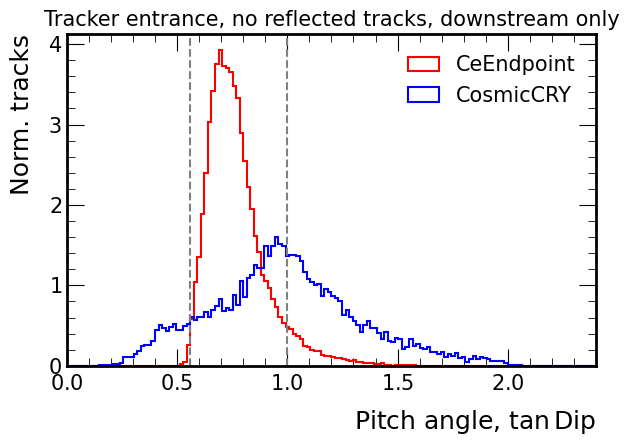

Wrote ../../img/comp/h1o_tandip_1.png


In [25]:
fig, ax = plt.subplots()

is_reflected_signal = selector.is_reflected(signal["trkfit"])
is_reflected_onspill = selector.is_reflected(onspill["trkfit"])

plot.plot_1D_overlay(
    {
        # "CeEndpoint" : ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        # "CosmicCRY" : ak.flatten(onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None),
        "CeEndpoint" : ak.flatten(signal["tan_dip"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["tan_dip"], axis=None)
    },
    nbins=150,xmin=0,xmax=2.4,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax,
    title="Tracker entrance, no reflected tracks, downstream only",
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
    ylabel="Norm. tracks"
)


ax.axvline(0.5577350, linestyle="--", color="grey")
ax.axvline(1.0, linestyle="--", color="grey")
plt.tight_layout()
out_path = f"../../img/comp/h1o_tandip_{tag}.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Wrote {out_path}")

## d_0 vs mom

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


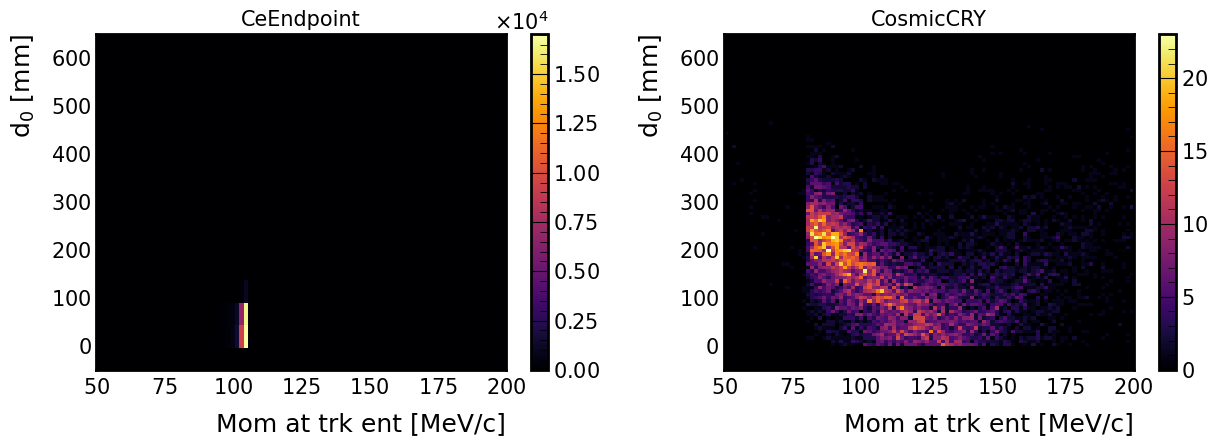

In [26]:
plotter=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

vector = Vector()

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(signal["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=15,ymin=-50,ymax=650,
    ax=ax[0],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CeEndpoint"
)

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(onspill["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=-50,ymax=650,
    ax=ax[1],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CosmicCRY"
)

plt.tight_layout()
plt.savefig(f"../../img/comp/h2_mom_vs_d0_{tag}.png", dpi=300)
plt.show()

# tanDip

what is the relationship with track z-momentum 

[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


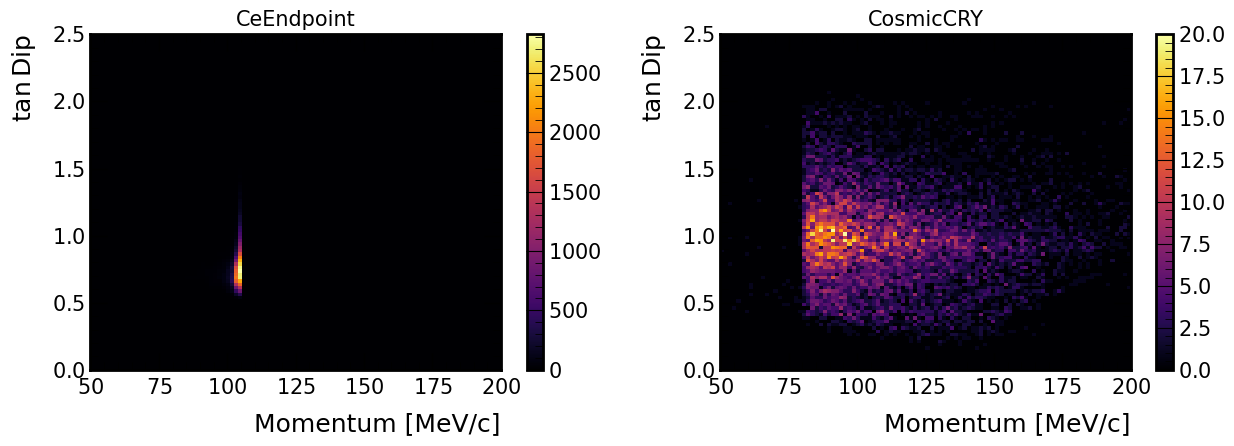

In [27]:
# plot=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(signal["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(signal["tan_dip"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=0,ymax=2.5,
    ax=ax[0],
    show=False,
    xlabel=r"Momentum [MeV/c]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title="CeEndpoint",
    log_z=False
)

plotter.plot_2D(
    x=ak.flatten(vector.get_mag(onspill["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(onspill["tan_dip"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=0,ymax=2.5,
    ax=ax[1],
    show=False,
    xlabel=r"Momentum [MeV/c]",
    ylabel=r"$\tan{\text{Dip}}$",
    title="CosmicCRY",
    log_z=False
)

plt.tight_layout()
plt.savefig(f"../../img/comp/h2_mom_vs_tandip_{tag}.png", dpi=300)
plt.show()

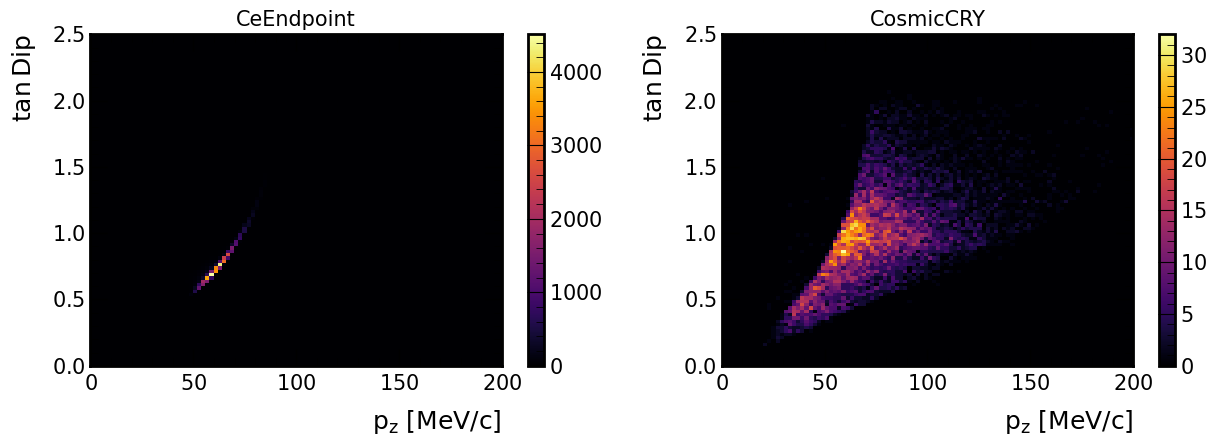

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plotter.plot_2D(
    x=ak.flatten(signal["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None),
    y=ak.flatten(signal["tan_dip"], axis=None),
    nbins_x=100,xmin=0,xmax=200,
    nbins_y=100,ymin=0,ymax=2.5,
    ax=ax[0],
    show=False,
    xlabel=r"$p_{z}$ [MeV/c]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title="CeEndpoint",
    log_z=False
)

plotter.plot_2D(
    x=ak.flatten(onspill["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"], axis=None),
    y=ak.flatten(onspill["tan_dip"], axis=None),
    nbins_x=100,xmin=0,xmax=200,
    nbins_y=100,ymin=0,ymax=2.5,
    ax=ax[1],
    show=False,
    xlabel=r"$p_{z}$ [MeV/c]",
    ylabel=r"$\tan{\text{Dip}}$",
    title="CosmicCRY",
    log_z=False
)

plt.tight_layout()
plt.savefig(f"../../img/comp/h2_pz_vs_tandip_{tag}.png", dpi=300)
plt.show()

## Correlations 

Wrote ../../img/comp/h2_trk_corr.png


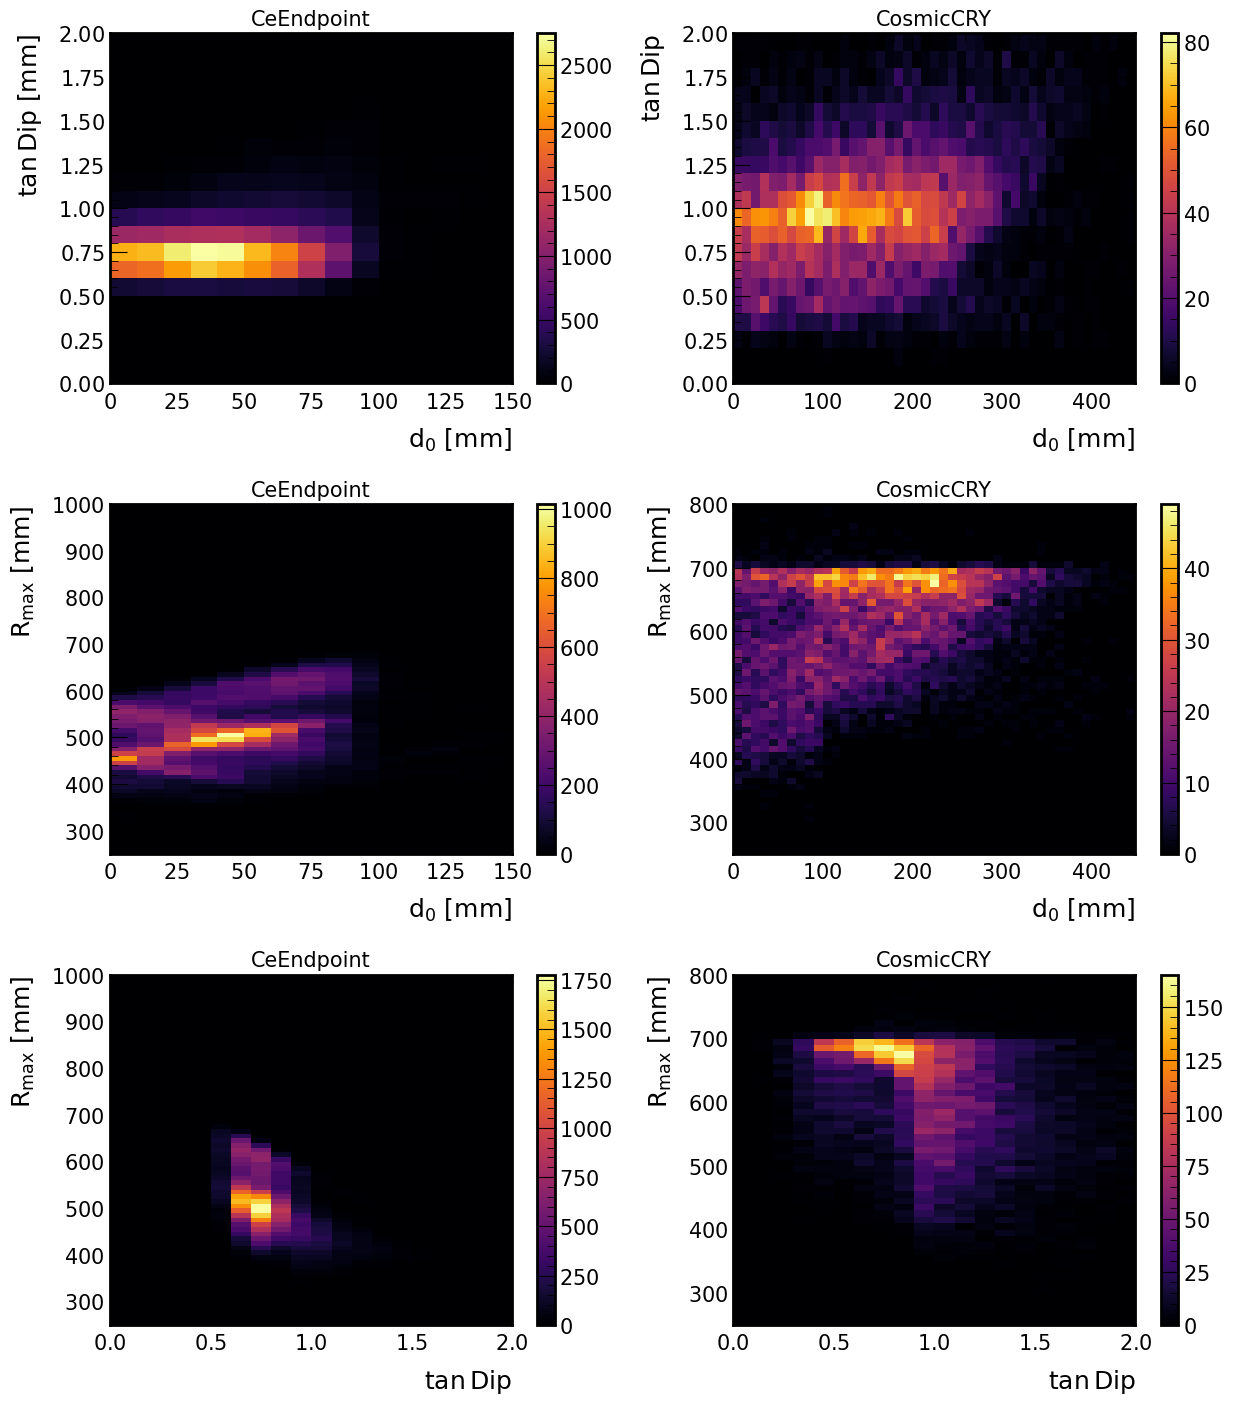

In [30]:
# Define your bin densities
BIN_DENSITY = {
    "d0": 0.1,      # bins per mm (10 mm per bin)
    "theta": 10,    # bins per tan(theta) (10 units per bin)
    "rmax": 0.1     # bins per mm (10 mm per bin)
}

# Define ranges
RANGES = {
    "signal_d0": (0, 150),
    "cosmic_d0": (0, 450), 
    "theta": (0, 2),
    "signal_rmax": (250, 1000),
    "cosmic_rmax": (250, 800)
}

def get_bins(param, range_key):
    """Calculate consistent bins based on density and range"""
    min_val, max_val = RANGES[range_key]
    n_bins = int((max_val - min_val) * BIN_DENSITY[param])
    return n_bins, min_val, max_val

# Create the plots with consistent binning
fig, ax = plt.subplots(3, 2, figsize=(6.4*2, 4.8*3))

# Signal: d0 vs tan(theta)
nbins_x, xmin, xmax = get_bins("d0", "signal_d0")      # 15 bins
nbins_y, ymin, ymax = get_bins("theta", "theta")       # 100 bins
plotter.plot_2D(
    x=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y=ak.flatten(signal["tan_dip"], axis=None),
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    ax=ax[0,0],
    show=False,
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$\tan{\text{Dip}}$ [mm]",
    title="CeEndpoint",
    # log_z=True
)

# Signal: d0 vs R_max
nbins_x, xmin, xmax = get_bins("d0", "signal_d0")      # 15 bins
nbins_y, ymin, ymax = get_bins("rmax", "signal_rmax")  # 75 bins
plotter.plot_2D(
    x=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y=ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    ax=ax[1,0],
    show=False,
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$R_{\text{max}}$ [mm]",
    title="CeEndpoint", 
    # log_z=True
)

# Cosmic: d0 vs tan(theta)
nbins_x, xmin, xmax = get_bins("d0", "cosmic_d0")      # 45 bins
nbins_y, ymin, ymax = get_bins("theta", "theta")       # 100 bins
plotter.plot_2D(
    x=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y=ak.flatten(onspill["tan_dip"], axis=None),
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    ax=ax[0,1],
    show=False,
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title="CosmicCRY",
    # log_z=True
)

# Cosmic: d0 vs R_max
nbins_x, xmin, xmax = get_bins("d0", "cosmic_d0")      # 45 bins
nbins_y, ymin, ymax = get_bins("rmax", "cosmic_rmax")  # 55 bins
plotter.plot_2D(
    x=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    ax=ax[1,1],
    show=False,
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$R_{\text{max}}$ [mm]",
    title="CosmicCRY", 
    # log_z=True
)

# Signal: tan(theta) vs R_max
nbins_x, xmin, xmax = get_bins("theta", "theta")       # 100 bins
nbins_y, ymin, ymax = get_bins("rmax", "signal_rmax")  # 75 bins
plotter.plot_2D(
    x=ak.flatten(signal["tan_dip"], axis=None),
    y=ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    ax=ax[2,0],
    show=False,
    xlabel=r"$\tan{\text{Dip}}$",
    ylabel=r"$R_{\text{max}}$ [mm]",
    title="CeEndpoint"
)

# Cosmic: tan(theta) vs R_max
nbins_x, xmin, xmax = get_bins("theta", "theta")       # 100 bins
nbins_y, ymin, ymax = get_bins("rmax", "cosmic_rmax")  # 55 bins
plotter.plot_2D(
    x=ak.flatten(onspill["tan_dip"], axis=None), 
    y=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    ax=ax[2,1],
    show=False,
    xlabel=r"$\tan{\text{Dip}}$",
    ylabel=r"$R_{\text{max}}$ [mm]", 
    title="CosmicCRY"
)

plt.tight_layout()
out_path = f"../../img/comp/h2_trk_corr.png"
plt.savefig(out_path, dpi=300)
print(f"Wrote {out_path}")
plt.show()

In [31]:
import awkward as ak
import pandas as pd
from scipy.stats import spearmanr

def compute_spearmanr(x, y):
    """
    Spearman correlation coefficients
    """
    x_np = ak.to_numpy(x)
    y_np = ak.to_numpy(y)
    
    # Handle missing or infinite values
    mask = (~pd.isnull(x_np)) & (~pd.isnull(y_np)) & (~pd.isna(x_np)) & (~pd.isna(y_np))
    x_np = x_np[mask]
    y_np = y_np[mask]
    
    if len(x_np) < 2:
        return float("nan"), float("nan"), float("nan")

    # Get coefficients
    spearman_r, _ = spearmanr(x_np, y_np)
                              
    return spearman_r

def classify(r):
    """Classify the strength of correlation based on |r|"""
    r_abs = abs(r)
    if r_abs < 0.1:
        return "None"
    elif r_abs < 0.3:
        return "Weak"
    elif r_abs < 0.5:
        return "Moderate"
    else:
        return "Strong"

def summarise_correlations(data_dict):
    """
    data_dict: dict of form {
        "Label": (x_array, y_array)
    }
    """
    rows = []
    for label, (x, y) in data_dict.items():
        spearman_r = compute_spearmanr(x, y)
        rows.append({
            "Label": label,
            r"Spearman $\rho$": spearman_r,
            "Strength": classify(spearman_r)
        })
    df = pd.DataFrame(rows)
    return df

# Flatten data
signal_d0 = ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None)
signal_theta = ak.flatten(signal["tan_dip"], axis=None)
signal_rmax = ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None)

cosmic_d0 = ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None)
cosmic_theta = ak.flatten(onspill["tan_dip"], axis=None)
cosmic_rmax = ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None)


correlations = summarise_correlations({
    r"CeEndPoint: d0 vs tanDip": (signal_d0, signal_theta),
    r"CeEndPoint: d0 vs Rmax": (signal_d0, signal_rmax),
    r"CeEndPoint: tanDip vs Rmax": (signal_theta, signal_rmax),
    r"CosmicCRY: d0 vs tanDip": (cosmic_d0, cosmic_theta),
    r"CosmicCRY: d0 vs Rmax": (cosmic_d0, cosmic_rmax),
    r"CosmicCRY: tanDip vs Rmax": (cosmic_theta, cosmic_rmax),
})

# Display with rounded values
display(correlations.round(3))
out_path = f"../../txt/comp/trk_corr.csv"
correlations.round(3).to_csv(out_path, index=False)
print("Wrote", out_path)

,Label,Spearman $\rho$,Strength
0,CeEndPoint: d0 vs tanDip,0.107,Weak
1,CeEndPoint: d0 vs Rmax,0.308,Moderate
2,CeEndPoint: tanDip vs Rmax,-0.453,Moderate
3,CosmicCRY: d0 vs tanDip,0.243,Weak
4,CosmicCRY: d0 vs Rmax,0.305,Moderate
5,CosmicCRY: tanDip vs Rmax,-0.338,Moderate


Wrote ../../txt/comp/trk_corr.csv


### This needs to be moved to pyutils

In [32]:
import matplotlib.colors as colors

# TODO: put this in pyplot
def plot_2D_overlay(
    # self,
    x1, y1, x2, y2,
    weights1=None, weights2=None,
    nbins_x=100,
    xmin=-1.0,
    xmax=1.0,
    nbins_y=100,
    ymin=-1.0,
    ymax=1.0,
    title=None,
    xlabel=None,
    ylabel=None,
    zlabel=None,
    out_path=None,
    cmap1="Blues",
    cmap2="Reds", 
    alpha=0.7,
    dpi=300,
    log_x=False,
    log_y=False,
    log_z=False,
    show_cbar=False,
    leg_pos="best",
    ax=None,
    show=True,
    labels=None
    ):

    """
    Plot two overlaid 2D histograms from two pairs of arrays with different colourmaps.
    
    Args:
        x1, y1 (np.ndarray): Arrays for first dataset
        x2, y2 (np.ndarray): Arrays for second dataset  
        weights1, weights2 (np.ndarray, optional): Optional weights for each dataset
        nbins_x (int): Number of bins in x. Defaults to 100
        xmin (float): Minimum x value. Defaults to -1.0
        xmax (float): Maximum x value. Defaults to 1.0
        nbins_y (int): Number of bins in y. Defaults to 100
        ymin (float): Minimum y value. Defaults to -1.0
        ymax (float): Maximum y value. Defaults to 1.0
        title (str, optional): Plot title
        xlabel (str, optional): X-axis label
        ylabel (str, optional): Y-axis label
        zlabel (str, optional): Colourbar label
        out_path (str, optional): Path to save the plot
        cmap1 (str): Matplotlib colourmap for first dataset. Defaults to "Blues"
        cmap2 (str): Matplotlib colourmap for second dataset. Defaults to "Reds"
        alpha (float): Transparency level. Defaults to 0.7
        dpi (int): DPI for saved plot. Defaults to 300
        log_x (bool): Use log scale for x-axis
        log_y (bool): Use log scale for y-axis
        log_z (bool): Use log scale for colour values
        show_cbar (bool): Whether to show colourbar. Defaults to False (not recommended for overlays)
        leg_pos (str): Legend position. Defaults to "best"
        ax (plt.Axes, optional): External custom axes.
        show (bool): Display the plot. Defaults to True
        labels (list, optional): Labels for legend ['Dataset1', 'Dataset2']
        
    Raises:
        ValueError: If input arrays are empty or different lengths
    """
    
    # Process first dataset
    x1 = ak.to_numpy(x1)
    y1 = ak.to_numpy(y1)
    
    # Filter out empty entries for dataset 1
    valid_indices1 = [i for i in range(len(x1)) if np.any(x1[i]) and np.any(y1[i])]
    x1 = [x1[i] for i in valid_indices1]
    y1 = [y1[i] for i in valid_indices1]

    if weights1 is not None:
        weights1 = [weights1[i] for i in valid_indices1]

    # Process second dataset
    x2 = ak.to_numpy(x2)
    y2 = ak.to_numpy(y2)
    
    # Filter out empty entries for dataset 2
    valid_indices2 = [i for i in range(len(x2)) if np.any(x2[i]) and np.any(y2[i])]
    x2 = [x2[i] for i in valid_indices2]
    y2 = [y2[i] for i in valid_indices2]

    if weights2 is not None:
        weights2 = [weights2[i] for i in valid_indices2]

    # Validate inputs
    if len(x1) == 0 or len(y1) == 0:
        self.logger.log("First dataset arrays are empty", "error")
        return None
    if len(x1) != len(y1):
        self.logger.log("First dataset arrays have different lengths", "error")
        return None
    if len(x2) == 0 or len(y2) == 0:
        self.logger.log("Second dataset arrays are empty", "error")
        return None
    if len(x2) != len(y2):
        self.logger.log("Second dataset arrays have different lengths", "error")
        return None
    
    # Create or use provided axes
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots()
        new_fig = True
    
    # Create 2D histograms
    hist1, _, _ = np.histogram2d(
        x1, y1,
        bins=[nbins_x, nbins_y],
        range=[[xmin, xmax], [ymin, ymax]],
        weights=weights1
    )
    
    hist2, _, _ = np.histogram2d(
        x2, y2,
        bins=[nbins_x, nbins_y],
        range=[[xmin, xmax], [ymin, ymax]],
        weights=weights2
    )

    # Set up normalisation
    # vmax = max(np.max(hist1), np.max(hist2))
    # norm = colors.Normalize(vmin=0, vmax=vmax)
    # norm2 = colors.Normalize(vmin=0, vmax=vmax)

    if log_z:
        norm = colors.LogNorm(vmin=max(1, np.min(hist1[hist1>0])), vmax=np.max(hist1))
        norm2 = colors.LogNorm(vmin=max(1, np.min(hist2[hist2>0])), vmax=np.max(hist2))
    else:
        norm1 = colors.Normalize(vmin=0, vmax=np.max(hist1))
        norm2 = colors.Normalize(vmin=0, vmax=np.max(hist2))


    
    # Plot the first 2D histogram
    im1 = ax.imshow(
        hist1.T,
        cmap=cmap1,
        extent=[xmin, xmax, ymin, ymax],
        aspect="auto",
        origin="lower",
        norm=norm1,
        alpha=1.0 # otherwise it will be washed out
    )
    
    # Overlay the second 2D histogram
    im2 = ax.imshow(
        hist2.T,
        cmap=cmap2,
        extent=[xmin, xmax, ymin, ymax],
        aspect="auto",
        origin="lower", 
        norm=norm2,
        alpha=alpha
    )

    # Configure axes scales
    if log_x:
        ax.set_xscale("log")
    if log_y:
        ax.set_yscale("log")

    # Add colourbar (optional, usually not recommended for overlays)
    cbar = None
    if show_cbar:
        # Show colourbar for first dataset only
        cbar = plt.colorbar(im1, ax=ax)
        cbar.set_label(zlabel)

    # Set labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Add legend if labels provided
    if labels and len(labels) >= 2:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=plt.cm.get_cmap(cmap1)(0.7), alpha=alpha, label=labels[0]),
            Patch(facecolor=plt.cm.get_cmap(cmap2)(0.7), alpha=alpha, label=labels[1])
        ]
        ax.legend(handles=legend_elements, loc=leg_pos)

    # Scientific notation
    plotter._scientific_notation(ax, cbar=cbar)

    if new_fig:
        # Draw
        plt.tight_layout()

    # Save if path provided
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
        logger.log(f"Wrote:\n\t{out_path}", "success")

    # Show if requested
    if show:
        plt.show()

/tmp/ipykernel_398667/3532827706.py:185: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  Patch(facecolor=plt.cm.get_cmap(cmap1)(0.7), alpha=alpha, label=labels[0]),
/tmp/ipykernel_398667/3532827706.py:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  Patch(facecolor=plt.cm.get_cmap(cmap2)(0.7), alpha=alpha, label=labels[1])


Wrote ../../img/comp/h2_trk_corr_overlay.png


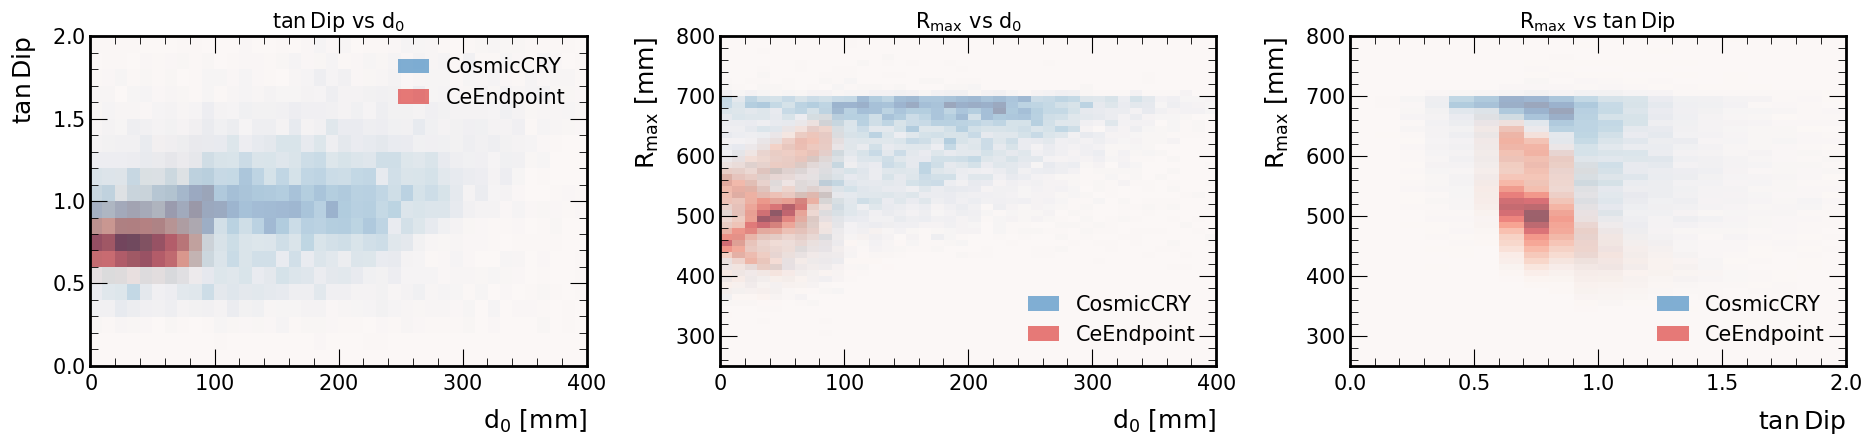

In [33]:
# Define your bin densities
BIN_DENSITY = {
    "d0": 0.1,      # bins per mm (10 mm per bin)
    "theta": 10,    # bins per tan(theta) (10 units per bin)
    "rmax": 0.1     # bins per mm (10 mm per bin)
}

# Define ranges (use the broader cosmic ranges for overlays)
RANGES = {
    "d0": (0, 400),       
    "theta": (0, 2),
    "rmax": (250, 800)   
}

def get_bins(param, range_key):
    """Calculate consistent bins based on density and range"""
    min_val, max_val = RANGES[range_key]
    n_bins = int((max_val - min_val) * BIN_DENSITY[param])
    return n_bins, min_val, max_val

# Create the plots with overlaid distributions
fig, ax = plt.subplots(1, 3, figsize=(6.4*3, 4.8*1))

# Transparency 
alpha = 0.6

# Plot 1: d0 vs tan(theta)
nbins_x, xmin, xmax = get_bins("d0", "d0")
nbins_y, ymin, ymax = get_bins("theta", "theta")

plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y1=ak.flatten(onspill["tan_dip"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y2=ak.flatten(signal["tan_dip"], axis=None),
    # Binning
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title=r"$\tan{\text{Dip}}$ vs $d_0$",
    ax=ax[0], show=False, leg_pos="upper right"
)

# Plot 2: d0 vs R_max
nbins_x, xmin, xmax = get_bins("d0", "d0")
nbins_y, ymin, ymax = get_bins("rmax", "rmax")

plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Binning
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$R_{\text{max}}$ [mm]",
    title=r"$R_{\text{max}}$ vs $d_0$",
    ax=ax[1], show=False, leg_pos="lower right"
)

# Plot 3: tan(theta) vs R_max
nbins_x, xmin, xmax = get_bins("theta", "theta")
nbins_y, ymin, ymax = get_bins("rmax", "rmax")

plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(onspill["tan_dip"], axis=None),
    y1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(signal["tan_dip"], axis=None),
    y2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Binning
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel=r"$\tan{\text{Dip}}$",
    ylabel=r"$R_{\text{max}}$ [mm]", 
    title=r"$R_{\text{max}}$ vs $\tan{\text{Dip}}$",
    ax=ax[2], show=False, leg_pos="lower right"
)

# ax[2].axvline(0.5577350, linestyle="--", color="grey")
# ax[2].axvline(1.0, linestyle="--", color="grey")

plt.tight_layout()
out_path = f"../../img/comp/h2_trk_corr_overlay.png"
plt.savefig(out_path, dpi=300)
print(f"Wrote {out_path}")
plt.show()

/tmp/ipykernel_398667/3532827706.py:185: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  Patch(facecolor=plt.cm.get_cmap(cmap1)(0.7), alpha=alpha, label=labels[0]),
/tmp/ipykernel_398667/3532827706.py:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  Patch(facecolor=plt.cm.get_cmap(cmap2)(0.7), alpha=alpha, label=labels[1])


Wrote ../../img/comp/h2o_trk_corr_overlay_with_cuts.png


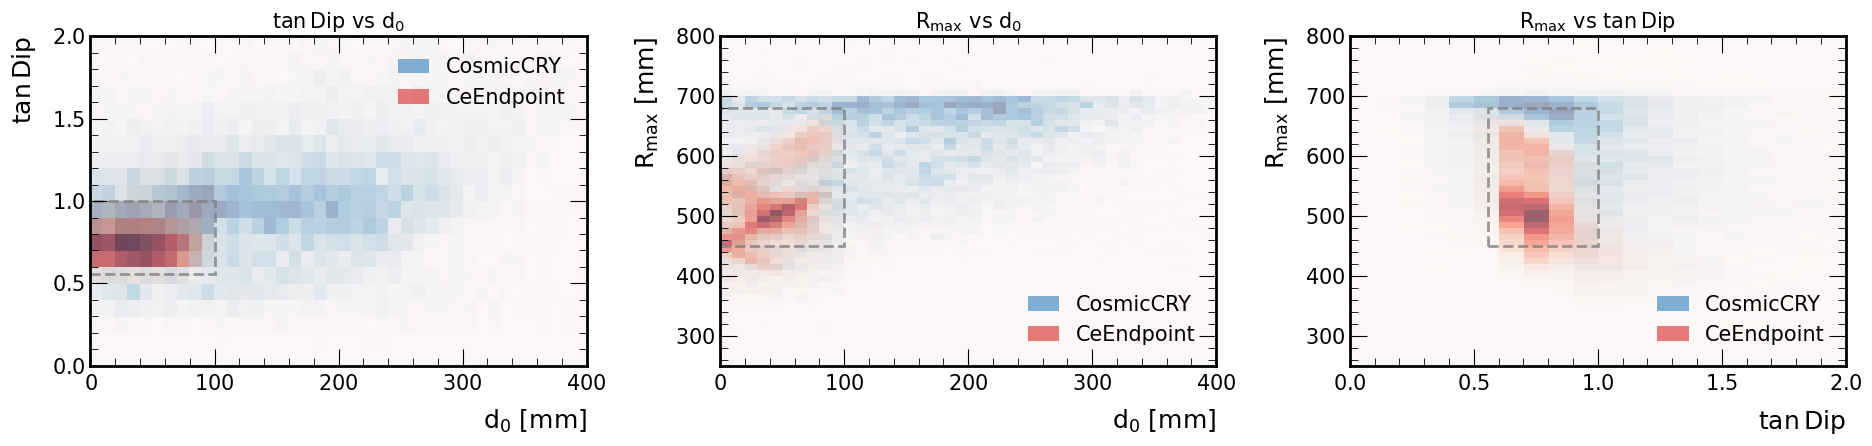

In [34]:
# Define your bin densities
BIN_DENSITY = {
    "d0": 0.1,      # bins per mm (10 mm per bin)
    "theta": 10,    # bins per tan(theta) (10 units per bin)
    "rmax": 0.1     # bins per mm (10 mm per bin)
}

# Define ranges (use the broader cosmic ranges for overlays)
RANGES = {
    "d0": (0, 400),       
    "theta": (0, 2),
    "rmax": (250, 800)   
}

# Define cut boxes - these correspond to your 1D cut lines
CUT_BOXES = {
    "d0_vs_theta": {
        "d0_min": 0, "d0_max": 100,  # d0 < 100 from your 1D plot
        "theta_min": 0.5577350, "theta_max": 1.0  # between your two tan(dip) lines
    },
    "d0_vs_rmax": {
        "d0_min": 0, "d0_max": 100,  # d0 < 100
        "rmax_min": 450, "rmax_max": 680  # between your two Rmax lines
    },
    "theta_vs_rmax": {
        "theta_min": 0.5577350, "theta_max": 1.0,  # between tan(dip) lines
        "rmax_min": 450, "rmax_max": 680  # between Rmax lines
    }
}

def get_bins(param, range_key):
    """Calculate consistent bins based on density and range"""
    min_val, max_val = RANGES[range_key]
    n_bins = int((max_val - min_val) * BIN_DENSITY[param])
    return n_bins, min_val, max_val

def add_cut_box(ax, box_params, box_style=None):
    """Add a rectangular cut box to the plot"""
    from matplotlib.patches import Rectangle
    
    if box_style is None:
        box_style = {
            'linewidth': 2,
            'edgecolor': 'grey',
            'facecolor': 'none',
            'linestyle': '--',
            'alpha': 0.8
        }
    
    # Extract box coordinates
    if 'd0_min' in box_params and 'd0_max' in box_params:
        x_min, x_max = box_params['d0_min'], box_params['d0_max']
    elif 'theta_min' in box_params and 'theta_max' in box_params:
        x_min, x_max = box_params['theta_min'], box_params['theta_max']
    
    if 'theta_min' in box_params and 'theta_max' in box_params and 'd0_min' not in box_params:
        y_min, y_max = box_params['rmax_min'], box_params['rmax_max']
    elif 'rmax_min' in box_params and 'rmax_max' in box_params:
        y_min, y_max = box_params['rmax_min'], box_params['rmax_max']
    elif 'theta_min' in box_params and 'theta_max' in box_params:
        y_min, y_max = box_params['theta_min'], box_params['theta_max']
    
    # Create rectangle
    width = x_max - x_min
    height = y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, **box_style)
    ax.add_patch(rect)

# Create the plots with overlaid distributions
fig, ax = plt.subplots(1, 3, figsize=(6.4*3, 4.8*1))

# Transparency 
alpha = 0.6

# Plot 1: d0 vs tan(theta)
nbins_x, xmin, xmax = get_bins("d0", "d0")
nbins_y, ymin, ymax = get_bins("theta", "theta")
plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y1=ak.flatten(onspill["tan_dip"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y2=ak.flatten(signal["tan_dip"], axis=None),
    # Binning
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$\tan{\text{Dip}}$",
    title=r"$\tan{\text{Dip}}$ vs $d_0$",
    ax=ax[0], show=False, leg_pos="upper right"
)
# Add cut box to first plot
add_cut_box(ax[0], CUT_BOXES["d0_vs_theta"])

# Plot 2: d0 vs R_max
nbins_x, xmin, xmax = get_bins("d0", "d0")
nbins_y, ymin, ymax = get_bins("rmax", "rmax")
plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    y2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Binning
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel=r"$d_{0}$ [mm]", 
    ylabel=r"$R_{\text{max}}$ [mm]",
    title=r"$R_{\text{max}}$ vs $d_0$",
    ax=ax[1], show=False, leg_pos="lower right"
)
# Add cut box to second plot
add_cut_box(ax[1], CUT_BOXES["d0_vs_rmax"])

# Plot 3: tan(theta) vs R_max
nbins_x, xmin, xmax = get_bins("theta", "theta")
nbins_y, ymin, ymax = get_bins("rmax", "rmax")
plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(onspill["tan_dip"], axis=None),
    y1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(signal["tan_dip"], axis=None),
    y2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Binning
    nbins_x=nbins_x, xmin=xmin, xmax=xmax,
    nbins_y=nbins_y, ymin=ymin, ymax=ymax,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel=r"$\tan{\text{Dip}}$",
    ylabel=r"$R_{\text{max}}$ [mm]", 
    title=r"$R_{\text{max}}$ vs $\tan{\text{Dip}}$",
    ax=ax[2], show=False, leg_pos="lower right"
)
# Add cut box to third plot
add_cut_box(ax[2], CUT_BOXES["theta_vs_rmax"])

plt.tight_layout()
out_path = f"../../img/comp/h2o_trk_corr_overlay_with_cuts.png"
plt.savefig(out_path, dpi=300)
print(f"Wrote {out_path}")
plt.show()

### Prototyping below

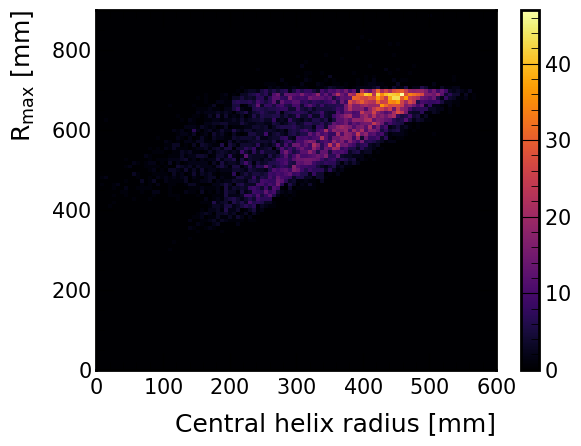

/tmp/ipykernel_398667/3532827706.py:185: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  Patch(facecolor=plt.cm.get_cmap(cmap1)(0.7), alpha=alpha, label=labels[0]),
/tmp/ipykernel_398667/3532827706.py:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  Patch(facecolor=plt.cm.get_cmap(cmap2)(0.7), alpha=alpha, label=labels[1])


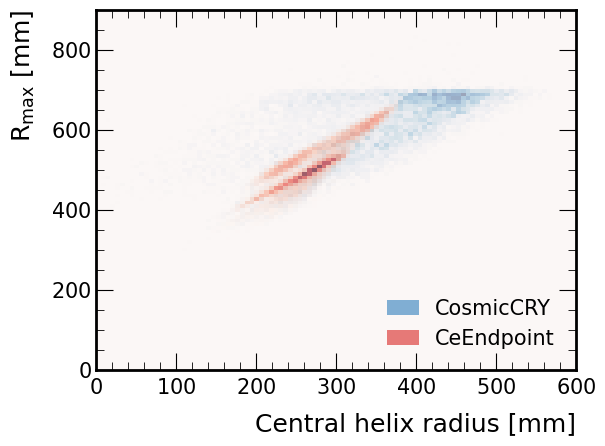

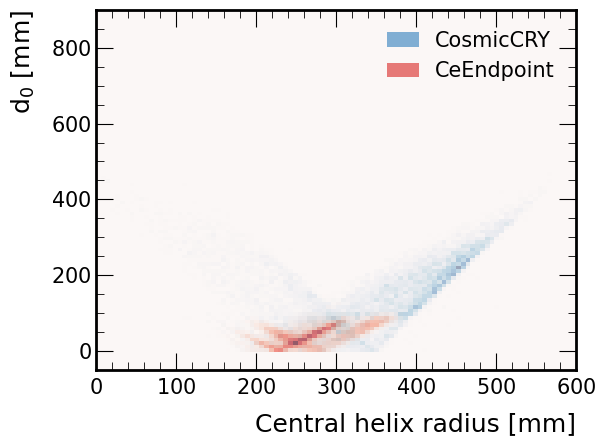

In [35]:
ct = ak.flatten(np.sqrt(onspill["trkfit"]["trksegpars_lh"]["cx"]**2 + onspill["trkfit"]["trksegpars_lh"]["cy"]**2), axis=None)
R_max = ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None)
# plt.scatter(ct, R_max)

plot.plot_2D(
    x=ct, y=R_max, nbins_x=100, xmin=0, xmax=600,  nbins_y=100, ymin=0, ymax=900,
    xlabel="Central helix radius [mm]", ylabel=r"$R_{max}$ [mm]",
)

plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(np.sqrt(onspill["trkfit"]["trksegpars_lh"]["cx"]**2 + onspill["trkfit"]["trksegpars_lh"]["cy"]**2), axis=None),
    y1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(np.sqrt(signal["trkfit"]["trksegpars_lh"]["cx"]**2 + signal["trkfit"]["trksegpars_lh"]["cy"]**2), axis=None),
    y2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None),
    # Binning
    nbins_x=100, xmin=0, xmax=600,
    nbins_y=100, ymin=0, ymax=900,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel="Central helix radius [mm]", ylabel=r"$R_{max}$ [mm]",
    # title=r"$R_{\text{max}}$ vs $\tan{\text{Dip}}$",
    show=True, leg_pos="lower right"
)

plot_2D_overlay(
    # First dataset (cosmic)
    x1=ak.flatten(np.sqrt(onspill["trkfit"]["trksegpars_lh"]["cx"]**2 + onspill["trkfit"]["trksegpars_lh"]["cy"]**2), axis=None),
    y1=ak.flatten(onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    # Second dataset (signal)  
    x2=ak.flatten(np.sqrt(signal["trkfit"]["trksegpars_lh"]["cx"]**2 + signal["trkfit"]["trksegpars_lh"]["cy"]**2), axis=None),
    y2=ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    # Binning
    nbins_x=100, xmin=0, xmax=600,
    nbins_y=100, ymin=-50, ymax=900,
    # Styling
    cmap1="Blues", cmap2="Reds", alpha=alpha,
    labels=["CosmicCRY", "CeEndpoint"],
    # Labels
    xlabel="Central helix radius [mm]", ylabel=r"$d_{0}$ [mm]",
    # title=r"$R_{\text{max}}$ vs $\tan{\text{Dip}}$",
    show=True, leg_pos="upper right"
)